In [3]:
# Загрузка библиотек необходимых для отрисовки графиков
import matplotlib
import math as mt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint, solve_ivp
%matplotlib inline

In [4]:
def calc_ws(
        gamma_wat: float
) -> float:
    """
    Функция для расчета солесодержания в воде

    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.

    :return: солесодержание в воде, г/г
    """
    ws = (
            1 / (gamma_wat * 1000)
            * (1.36545 * gamma_wat * 1000 - (3838.77 * gamma_wat * 1000 - 2.009 * (gamma_wat * 1000) ** 2) ** 0.5)
    )
    # если значение отрицательное, значит скорее всего плотность ниже допустимой 992 кг/м3
    if ws > 0:
        return ws
    else:
        return 0


def calc_rho_w(
        ws: float,
        t: float
) -> float:
    """
    Функция для расчета плотности воды в зависимости от температуры и солесодержания

    :param ws: солесодержание воды, г/г
    :param t: температура, К

    :return: плотность воды, кг/м3
    """
    rho_w = 1000 * (1.0009 - 0.7114 * ws + 0.2605 * ws ** 2) ** (-1)

    return rho_w / (1 + (t - 273) * 1e-4 * (0.269 * (t - 273) ** 0.637 - 0.8))


def calc_mu_w(
        ws: float,
        t: float,
        p: float
) -> float:
    """
    Функция для расчета динамической вязкости воды по корреляции Matthews & Russel

    :param ws: солесодержание воды, г/г
    :param t: температура, К
    :param p: давление, Па

    :return: динамическая вязкость воды, сПз
    """
    a = (
            109.574
            - (0.840564 * 1000 * ws)
            + (3.13314 * 1000 * ws ** 2)
            + (8.72213 * 1000 * ws ** 3)
    )
    b = (
            1.12166
            - 2.63951 * ws
            + 6.79461 * ws ** 2
            + 54.7119 * ws ** 3
            - 155.586 * ws ** 4
    )

    mu_w = (
            a * (1.8 * t - 460) ** (-b)
            * (0.9994 + 0.0058 * (p * 1e-6) + 0.6534 * 1e-4 * (p * 1e-6) ** 2)
    )
    return mu_w


def calc_n_re(
        rho_w: float,
        q_ms: float,
        mu_w: float,
        d_tub: float
) -> float:
    """
    Функция для расчета числа Рейнольдса

    :param rho_w: плотность воды, кг/м3
    :param q_ms: дебит жидкости, м3/с
    :param mu_w: динамическая вязкость воды, сПз
    :param d_tub: диаметр НКТ, м

    :return: число Рейнольдса, безразмерн.
    """
    v = q_ms / (np.pi * d_tub ** 2 / 4)
    return rho_w * v * d_tub / mu_w * 1000


def calc_ff_churchill(
        n_re: float,
        roughness: float,
        d_tub: float
) -> float:
    """
    Функция для расчета коэффициента трения по корреляции Churchill

    :param n_re: число Рейнольдса, безразмерн.
    :param roughness: шероховатость стен трубы, м
    :param d_tub: диаметр НКТ, м

    :return: коэффициент трения, безразмерн.
    """
    a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
    b = (37530 / n_re) ** 16

    ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
    return ff


def calc_ff_churchill(
        n_re: float,
        roughness: float,
        d_tub: float
) -> float:
    """
    Функция для расчета коэффициента трения по корреляции Churchill

    :param n_re: число Рейнольдса, безразмерн.
    :param roughness: шероховатость стен трубы, м
    :param d_tub: диаметр НКТ, м

    :return: коэффициент трения, безразмерн.
    """
    a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
    b = (37530 / n_re) ** 16

    ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
    return ff

def calc_ff_jain(
        n_re: float,
        roughness: float,
        d_tub: float
) -> float:
    """
    Функция для расчета коэффициента трения по корреляции Jain

    :param n_re: число Рейнольдса, безразмерн.
    :param roughness: шероховатость стен трубы, м
    :param d_tub: диаметр НКТ, м

    :return: коэффициент трения, безразмерн.
    """
    if n_re < 3000:
        ff = 64 / n_re
    else:
        ff = 1 / (1.14 - 2 * np.log10(roughness / d_tub + 21.25 / (n_re**0.9))) ** 2
    return ff

In [5]:
def calc_dp_dl_grav(rho_w: float, angle: float):
    """
    Функция для расчета градиента на гравитацию

    :param rho_w: плотность воды, кг/м3
    :param angle: угол наклона скважины к горизонтали, градусы

    :return: градиент давления на гравитацию в трубе, Па/м
    """
    dp_dl_grav = rho_w * 9.81 * np.sin(angle / 180 * np.pi)
    return dp_dl_grav

def calc_dp_dl_fric(
        rho_w: float,
        mu_w: float,
        q_ms: float,
        d_tub: float,
        roughness: float
):
    """
    Функция для расчета градиента давления на трение

    :param rho_w: плотность воды, кг/м3
    :param mu_w: динамическая вязкость воды, сПз
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: градиент давления в трубе, Па/м
    """
    if q_ms != 0:
        n_re = calc_n_re(rho_w, q_ms, mu_w, d_tub)
        ff = calc_ff_churchill(n_re, roughness, d_tub)
        dp_dl_fric = ff * rho_w * q_ms ** 2 / d_tub ** 5
    else:
        dp_dl_fric = 0
    return dp_dl_fric

def calc_dp_dl(
        rho_w: float,
        mu_w: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> float:
    """
    Функция для расчета градиента давления в трубе

    :param rho_w: плотность воды, кг/м3
    :param mu_w: динамическая вязкость воды, сПз
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: градиент давления в трубе, Па/м
    """
    dp_dl_grav = calc_dp_dl_grav(rho_w, angle)

    dp_dl_fric = calc_dp_dl_fric(rho_w, mu_w, q_ms, d_tub, roughness)

    dp_dl = dp_dl_grav - 0.815 * dp_dl_fric

    return dp_dl

In [6]:
def __integr_func(
        h: float,
        pt: tuple,
        temp_grad: float,
        gamma_wat: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> tuple:
    """
    Функция для интегрирования трубы

    :param h: текущая глубина, м
    :param pt: текущее давление, Па и текущая температура, К
    :param temp_grad: геотермический градиент, К/м * (1e-2)
    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: градиенты давления, Па/м и температуры, К/м
    """
    # Распаковка текущих значений давления и температуры
    p, t = pt

    # Расчет солесодержания
    ws = calc_ws(gamma_wat)

    # Расчет плотности воды
    rho_w = calc_rho_w(ws, t)

    # Расчет вязкости воды
    mu_w = calc_mu_w(ws, t, p)

    # Расчет градиента давления
    dp_dl = calc_dp_dl(rho_w, mu_w, angle, q_ms, d_tub, roughness)

    # Расчет градиента температуры (основывается на геотермическом градиенте)
    dt_dl = temp_grad

    return dp_dl, dt_dl


def calc_pipe(
        p_wh: float,
        t_wh: float,
        h0: float,
        md_vdp: float,
        temp_grad: float,
        gamma_wat: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> tuple:
    """
    Функция для расчета давления в трубе

    :param p_wh: буферное давление, Па
    :param t_wh: температура жидкости у буферной задвижки, К
    :param h0: начальная глубина, м
    :param md_vdp: глубина верхних дыр перфорации, м
    :param temp_grad: геотермический градиент, К/м * (1e-2)
    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: давление, Па и температура, K, глубины
    """
    # Начальные условия
    h = h0
    p = p_wh
    t = t_wh

    # Шаг интегрирования
    step = 10  # м

    # Подготовка массивов для хранения результатов
    pressures = [p]
    temperatures = [t]
    depths = [h]

    # Цикл численного интегрирования
    while h < md_vdp:
        # Получение градиентов из внешней функции __integr_func
        dp_dl, dt_dl = __integr_func(h, (p, t), temp_grad, gamma_wat, angle, q_ms, d_tub, roughness)

        # Обновление параметров
        p += dp_dl * step
        t += dt_dl * step
        h += step

        # Сохранение результатов
        pressures.append(p)
        temperatures.append(t)
        depths.append(h)

    return np.array(pressures), np.array(temperatures), np.array(depths)

def calc_p_wf(
        p_wh: float,
        t_wh: float,
        h0: float,
        md_vdp: float,
        temp_grad: float,
        gamma_wat: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> float:
    """
    Функция для расчета давления на забое скважины

    :param p_wh: буферное давление, Па
    :param t_wh: температура жидкости у буферной задвижки, К
    :param h0: начальная глубина, м
    :param md_vdp: глубина верхних дыр перфорации, м
    :param temp_grad: геотермический градиент, К/м * (1e-2)
    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: давление на забое скважины, Па
    """
    # Расчёт давления и температуры по всей длине трубы
    pressures, _, depths = calc_pipe(
        p_wh=p_wh,
        t_wh=t_wh,
        h0=h0,
        md_vdp=md_vdp,
        temp_grad=temp_grad,
        gamma_wat=gamma_wat,
        angle=angle,
        q_ms=q_ms,
        d_tub=d_tub,
        roughness=roughness
    )

    # Определение давления на забое как последнего значения в массиве
    p_wf = pressures[-1]
    return p_wf

In [29]:
import json
# Загрузка данных из json
with open('9.json') as json_file:
    data = json.load(json_file)

# Извлечение параметров из json
gamma_water = data.get('gamma_water')
H = data.get('md_vdp')
d_tub = data.get('d_tub')
angle = data.get('angle')
roughness = data.get('roughness')
p_wh = data.get('p_wh') * 101325
t_wh = data.get('t_wh') + 273
temp_grad = data.get('temp_grad') / 100

# Проверка, что все параметры загружены
required_params = [gamma_water, H, d_tub, angle, roughness, p_wh, t_wh, temp_grad]
if None in required_params:
    raise ValueError("Некоторые параметры отсутствуют в JSON файле.")

# Создание массива дебитов
Q = np.linspace(0, 400, 100)

# Список для записи результатов давления
press = []

# Расчеты
for q in Q:
    p = calc_p_wf(p_wh, t_wh, 0, H, temp_grad, gamma_water, angle, q / 86400, d_tub, roughness)
    press.append(p / 101325)  # Конвертируем давление в атм

# Формирование результатов
res = {
    'q_liq': Q.tolist(),  # Преобразуем массив numpy в список
    'p_wf': press
}

# Сохранение результатов в json
with open('output.json', 'w') as file:
    json.dump(res, file, indent=4)


{'q_liq': [0.0, 4.040404040404041, 8.080808080808081, 12.121212121212121, 16.161616161616163, 20.202020202020204, 24.242424242424242, 28.282828282828284, 32.323232323232325, 36.36363636363637, 40.40404040404041, 44.44444444444445, 48.484848484848484, 52.525252525252526, 56.56565656565657, 60.60606060606061, 64.64646464646465, 68.68686868686869, 72.72727272727273, 76.76767676767678, 80.80808080808082, 84.84848484848486, 88.8888888888889, 92.92929292929294, 96.96969696969697, 101.01010101010101, 105.05050505050505, 109.0909090909091, 113.13131313131314, 117.17171717171718, 121.21212121212122, 125.25252525252526, 129.2929292929293, 133.33333333333334, 137.37373737373738, 141.41414141414143, 145.45454545454547, 149.4949494949495, 153.53535353535355, 157.5757575757576, 161.61616161616163, 165.65656565656568, 169.69696969696972, 173.73737373737376, 177.7777777777778, 181.81818181818184, 185.85858585858588, 189.89898989898992, 193.93939393939394, 197.97979797979798, 202.02020202020202, 206.06

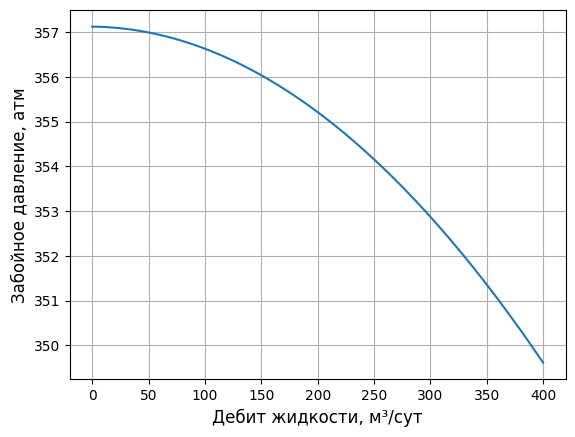

In [34]:
print(res)
plt.plot(Q, press)
plt.xlabel("Дебит жидкости, м³/сут", fontsize=12)
plt.ylabel("Забойное давление, атм", fontsize=12)
plt.grid()